# Predicting Mortality of ICU Patients: the PhysioNet/Computing in Cardiology Challenge 2012

__Make sure to have required dataset in same working directory or else give abbsolute or relative path to the file__

In [11]:
# importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import sklearn 
import numpy as np

In [12]:
# checking current working directory
os.getcwd()

'/Users/syedmeesumalizaidi'

In [13]:
# reading dataframe from csv file
df = pd.read_csv("final_data_with_slopes.csv")

In [14]:
# removing unnecessary columns.
df = df.drop(columns=['Height_last','Height_max','Height_med','Height_min','Height_mode','Height_slope','Height_std',
'Gender_last','Gender_max','Gender_med','Gender_min','Gender_mode','Gender_slope','Gender_std',
'Age_last','Age_max','Age_med','Age_min','Age_mode','Age_slope','Age_std','Unnamed: 0',
'SAPS-I','SOFA','Length_of_stay','Survival','ICUType_first','ICUType_last','ICUType_max','ICUType_med','ICUType_min','ICUType_mode','ICUType_slope','ICUType_std'])

In [15]:
record_col = df["RecordID"]
df = df.drop(columns=['RecordID'])

## Outcome-related Descriptors
The outcome-related descriptors are kept in a separate CSV text file for each of the three record sets; as noted, only the file associated with training set A is available to participants. Each line of the outcomes file contains these descriptors:

- RecordID (defined as above)
- SAPS-I score (Le Gall et al., 1984)
- SOFA score (Ferreira et al., 2001)
- Length of stay (days)
- Survival (days)
- In-hospital death (0: survivor, or 1: died in-hospital)

The **Length of stay** is the number of days between the patient's admission to the ICU and the end of hospitalization (including any time spent in the hospital after discharge from the ICU). If the patient's death was recorded (in or out of hospital), then **Survival** is the number of days between ICU admission and death; otherwise, Survival is assigned the value -1. Since patients who spent less than 48 hours in the ICU have been excluded, Length of stay and Survival never have the values 0 or 1 in the challenge data sets. Given these definitions and constraints,

                            Survival > Length of stay  ⇒  Survivor
                            Survival = -1  ⇒  Survivor
                            2 ≤ Survival ≤ Length of stay  ⇒  In-hospital death

reference: https://physionet.org/challenge/2012/


In [16]:
# separating target column from dataframe
target_col = df["In-hospital_death"]
df = df.drop(columns=['In-hospital_death'])

**A correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables. A correlation matrix is used as a way to summarize data, as an input into a more advanced analysis, and as a diagnostic for advanced analyses.**
[ https://www.displayr.com/what-is-a-correlation-matrix/ ]

In [21]:
# Create correlation matrix with absolute values
corr_matrix = df.corr().abs()

In [ ]:
corr_matrix.fillna(0).style.background_gradient(cmap='coolwarm')

In [ ]:
f = plt.figure(figsize=(100, 100))
sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, cmap='coolwarm')
plt.savefig('Correlation Matrix SNS.png')

In [ ]:
f = plt.figure(figsize=(100, 100))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, rotation=90)
plt.yticks(range(df.shape[1]), df.columns)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=40)
plt.title('Correlation Matrix', fontsize=50);
plt.savefig('Correlation Matrix.png')

In [ ]:
f = plt.figure(figsize=(25, 25))
ax = sns.heatmap(
    corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);
plt.savefig("corr_mat_sns_modified.png")

In [47]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [48]:
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [54]:
corr_matrix[to_drop].fillna(0).style.background_gradient(cmap='coolwarm')

In [55]:
# Drop features 
df = df.drop(df[to_drop], axis=1)

In [ ]:
#Ridge regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge,RidgeCV
ridgeCV = RidgeCV(cv=5)
parameters = {'alpha':[1e-15,1e-10,1e-8,1e-4,1e-3,1e-2,1,5,10,20]}
# ridge_regressor = GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)

# ridge_regressor.fit(df,target_col)
# print(ridge_regressor.best_params_)
# print(ridge_regressor.best_score_)

from sklearn.linear_model import Lasso,LassoCV
# lasso = Lasso()
lassoCV = LassoCV(cv=5)
# parameters = {'alpha':[1e-15,1e-10,1e-8,1e-4,1e-3,1e-2,1,5,10,20]}
# lasso_regressor = GridSearchCV(lasso,parameters,scoring='neg_mean_squared_error',cv=5)
# lassoCV_regressor = GridSearchCV(lassoCV,parameters,scoring='neg_mean_squared_error',cv=5)

# lasso_regressor.fit(df,target_col)
# print(lasso_regressor.best_params_)
# print(lasso_regressor.best_score_)

lassoCV.fit(df,target_col)
# RidgeCV()
print("Best alpha using built-in LassoCV: %f" % lassoCV.alpha_)
print("Best score using built-in LassoCV: %f" %lassoCV.score(df,target_col))
coef = pd.Series(lassoCV.coef_, index = df.columns)

# print("Best alpha using built-in RidgeCV: %f" % RidgeCV.alpha_)
# print("Best score using built-in RidgeCV: %f" %RidgeCV.score(df,target_col))
# coef_ridge = pd.Series(RidgeCV.coef_, index = df.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
# print("Ridge picked " + str(sum(coef_ridge != 0)) + " variables and eliminated the other " +  str(sum(coef_ridge == 0)) + " variables")

imp_coef = coef.sort_values()
plt.figure(figsize=(1,50))
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

selected_coefs = imp_coef[imp_coef.values != 0]

selected_coefs.index

df_new = df[selected_coefs.index.tolist()]

df_new.columns

In [58]:
df_new.columns.tolist()

['GCS_last',
 'PaCO2_first',
 'ALP_std',
 'Glucose_std',
 'NIDiasABP_mode',
 'NIMAP_mode',
 'NIMAP_last',
 'Weight_last',
 'NISysABP_last',
 'SysABP_max',
 'DiasABP_last',
 'PaO2_med',
 'Glucose_min',
 'PaO2_max',
 'MAP_min',
 'Platelets_first',
 'ALT_min',
 'Height_first',
 'MAP_last',
 'BUN_first',
 'ALT_last',
 'NIDiasABP_last',
 'AST_first',
 'NISysABP_min',
 'SysABP_last',
 'PaO2_first',
 'AST_med',
 'PaO2_last',
 'Urine_last',
 'Urine_min',
 'Urine_max',
 'NIDiasABP_med',
 'Cholesterol_first',
 'AST_std',
 'Urine_first',
 'AST_last',
 'AST_max',
 'ALT_med',
 'Urine_mode',
 'NISysABP_med',
 'MAP_mode',
 'Platelets_last',
 'ALT_first',
 'PaO2_std',
 'AST_min',
 'SysABP_first',
 'PaO2_min',
 'pH_max',
 'MAP_first',
 'PaO2_mode',
 'Glucose_max',
 'ALP_last',
 'Glucose_last',
 'HR_last',
 'HR_max',
 'WBC_last',
 'Age_first',
 'BUN_last',
 'Bilirubin_first']

In [59]:
#import the necessary module
from sklearn.model_selection import train_test_split
#split data set into train and test sets
data_train, data_test, target_train, target_test = train_test_split(df,target_col, test_size = 0.20, random_state = 10)
#split data set with lasso selected features
data_new_train, data_new_test, target_train, target_test = train_test_split(df_new,target_col, test_size = 0.20, random_state = 10)

In [62]:
# import the necessary module
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
#create an object of the type GaussianNB
gnb = GaussianNB()
#train the algorithm on training data and predict using the testing data
pred = gnb.fit(data_train, target_train).predict(data_test)
#print(pred.tolist())
#print the accuracy score of the model
print("Naive-Bayes accuracy : ",accuracy_score(target_test, pred, normalize = True))
#train the algorithm on lasso selected training data and predict using the lasso selected testing data
pred = gnb.fit(data_new_train, target_train).predict(data_new_test)
print("Naive-Bayes accuracy (lasso) : ",accuracy_score(target_test, pred, normalize = True))

Naive-Bayes accuracy :  0.80375
Naive-Bayes accuracy (lasso) :  0.855


In [65]:
#import the necessary modules
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
#create an object of type LinearSVC
svc_model = LinearSVC(random_state=10)
#train the algorithm on training data and predict using the testing data
pred = svc_model.fit(data_train, target_train).predict(data_test)
#print the accuracy score of the model
print("LinearSVC accuracy : ",accuracy_score(target_test, pred, normalize = True))
#train the algorithm on lasso selected training data and predict using the lasso selected testing data
pred = svc_model.fit(data_new_train, target_train).predict(data_new_test)
#print the accuracy score of the model
print("LinearSVC accuracy (lasso) : ",accuracy_score(target_test, pred, normalize = True))

/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC accuracy :  0.85
LinearSVC accuracy (lasso) :  0.84875


/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [66]:
#import necessary modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
#create object of the lassifier
neigh = KNeighborsClassifier(n_neighbors=3)
#Train the algorithm
neigh.fit(data_train, target_train)
# predict the response
pred = neigh.predict(data_test)
# evaluate accuracy
print ("KNeighbors accuracy score : ",accuracy_score(target_test, pred))

#Train the algorithm with Lasso selected data
neigh.fit(data_new_train, target_train)
# predict the response with lasso selected data
pred = neigh.predict(data_new_test)
# evaluate accuracy
print ("KNeighbors accuracy score (lasso) : ",accuracy_score(target_test, pred))

KNeighbors accuracy score :  0.8675
KNeighbors accuracy score (lasso) :  0.865


In [67]:
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [68]:
GPC = GaussianProcessClassifier(1.0 * RBF(1.0))
Dtree = DecisionTreeClassifier(max_depth=6)
Rforest = RandomForestClassifier(max_depth=6, n_estimators=10)
NN = MLPClassifier(alpha=0.05, 
                   hidden_layer_sizes=(50, 100, 50),
                   activation='tanh',
                   learning_rate='constant',
                   solver='adam',
                   max_iter=1500)
# Best parameters found:
#  {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
AdaBoost = AdaBoostClassifier()
QuardDisc = QuadraticDiscriminantAnalysis()

In [69]:
#import cross validation from sklearn
from sklearn.model_selection import cross_val_score

In [70]:
#GNB accuracy
scores = cross_val_score(gnb, df, target_col, cv=5)
print("GNB Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# with lasso
scores = cross_val_score(gnb, df_new, target_col, cv=5)
print("GNB Accuracy (lasso): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

GNB Accuracy: 0.80 (+/- 0.04)
GNB Accuracy (lasso): 0.84 (+/- 0.02)


In [71]:
#LinearSVC accuracy
scores = cross_val_score(svc_model, df, target_col, cv=5)
print("LinearSVC Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# with lasso
scores = cross_val_score(svc_model, df_new, target_col, cv=5)
print("LinearSVC Accuracy (lasso): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the

LinearSVC Accuracy: 0.71 (+/- 0.57)


/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC Accuracy (lasso): 0.86 (+/- 0.01)


/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [72]:
#KNeighbors accuracy
scores = cross_val_score(neigh, df, target_col, cv=5)
print("KNeighbors Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#KNeighbors accuracy with lasso
scores = cross_val_score(neigh, df_new, target_col, cv=5)
print("KNeighbors Accuracy(lasso): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

KNeighbors Accuracy: 0.85 (+/- 0.01)
KNeighbors Accuracy(lasso): 0.84 (+/- 0.01)


In [73]:
#GPC accuracy
scores = cross_val_score(GPC, df, target_col, cv=5)
print("GPC Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#GPC accuracy with lasso
scores = cross_val_score(GPC, df_new, target_col, cv=5)
print("GPC Accuracy (lasso): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

GPC Accuracy: 0.86 (+/- 0.00)
GPC Accuracy (lasso): 0.86 (+/- 0.00)


In [74]:
#Dtree accuracy
scores = cross_val_score(Dtree, df, target_col, cv=5)
print("Dtree Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#Dtree accuracy with lasso
scores = cross_val_score(Dtree, df_new, target_col, cv=5)
print("Dtree Accuracy (lasso): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dtree Accuracy: 0.85 (+/- 0.01)
Dtree Accuracy (lasso): 0.85 (+/- 0.01)


In [75]:
#Rforest accuracy
scores = cross_val_score(Rforest, df, target_col, cv=5)
print("Rforest Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#Rforest accuracy with lasso
scores = cross_val_score(Rforest, df_new, target_col, cv=5)
print("Rforest Accuracy (lasso): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Rforest Accuracy: 0.87 (+/- 0.01)
Rforest Accuracy (lasso): 0.87 (+/- 0.01)


In [76]:
#NN accuracy
scores = cross_val_score(NN, df, target_col, cv=5)
print("NN Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#NN accuracy with lasso
scores = cross_val_score(NN, df_new, target_col, cv=5)
print("NN Accuracy (lasso): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

NN Accuracy: 0.86 (+/- 0.00)
NN Accuracy (lasso): 0.86 (+/- 0.01)


In [77]:
#AdaBoost accuracy
scores = cross_val_score(AdaBoost, df, target_col, cv=5)
print("AdaBoost Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#AdaBoost accuracy with lasso
scores = cross_val_score(AdaBoost, df_new, target_col, cv=5)
print("AdaBoost Accuracy (lasso): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

AdaBoost Accuracy: 0.87 (+/- 0.01)
AdaBoost Accuracy (lasso): 0.87 (+/- 0.01)


In [78]:
#QuardDisc accuracy
scores = cross_val_score(QuardDisc, df, target_col, cv=5)
print("QuardDisc Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#QuardDisc accuracy with lasso
scores = cross_val_score(QuardDisc, df_new, target_col, cv=5)
print("QuardDisc Accuracy (lasso): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/ana

QuardDisc Accuracy: 0.79 (+/- 0.05)
QuardDisc Accuracy (lasso): 0.84 (+/- 0.02)


In [79]:
#pip install yellowbrick (if installing standalone)
#conda install -c districtdatalabs yellowbrick (if installing in anaconda)
#import classification report from yellowbrick
from yellowbrick.classifier import ClassificationReport

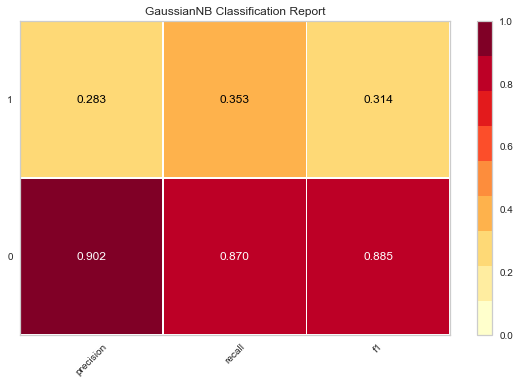

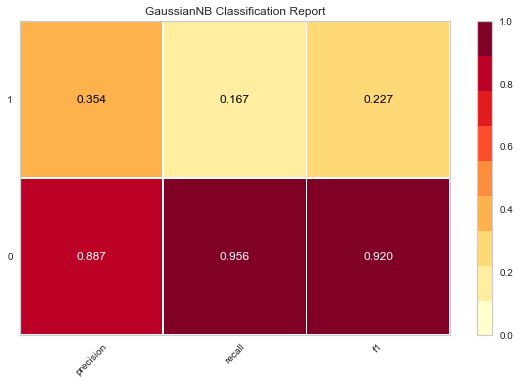

In [80]:
#GNB Accuracy Visualisation
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(gnb, classes=[0,1])
visualizer.fit(data_train, target_train) # Fit the training data to the visualizer
visualizer.score(data_test, target_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

#GNB Accuracy Visualisation with lasso
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(gnb, classes=[0,1])
visualizer.fit(data_new_train, target_train) # Fit the training data to the visualizer
visualizer.score(data_new_test, target_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


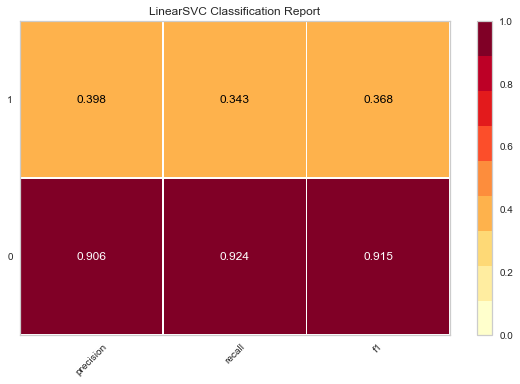

/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


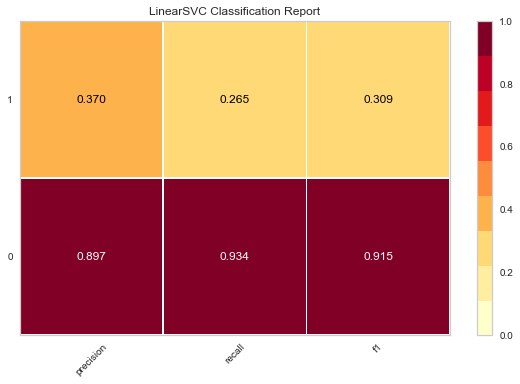

In [81]:
#LinearSVC Accuracy Visualisation
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(svc_model, classes=[0,1])
visualizer.fit(data_train, target_train) # Fit the training data to the visualizer
visualizer.score(data_test, target_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

#LinearSVC Accuracy Visualisation with lasso
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(svc_model, classes=[0,1])
visualizer.fit(data_new_train, target_train) # Fit the training data to the visualizer
visualizer.score(data_new_test, target_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

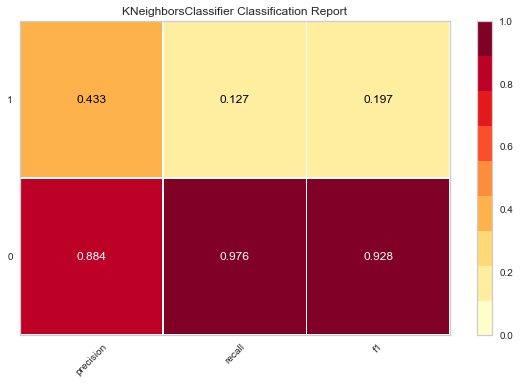

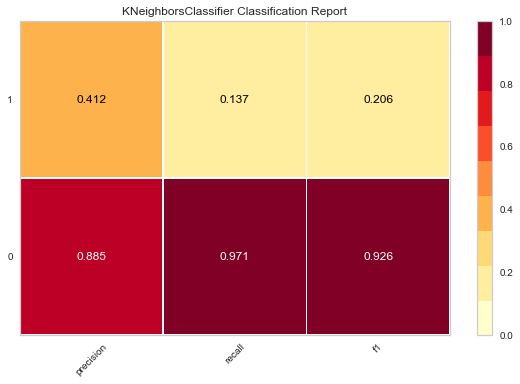

In [82]:
#KNeighbors Accuracy Visualisation
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(neigh, classes=[0,1])
visualizer.fit(data_train, target_train) # Fit the training data to the visualizer
visualizer.score(data_test, target_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

#KNeighbors Accuracy Visualisation with lasso
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(neigh, classes=[0,1])
visualizer.fit(data_new_train, target_train) # Fit the training data to the visualizer
visualizer.score(data_new_test, target_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


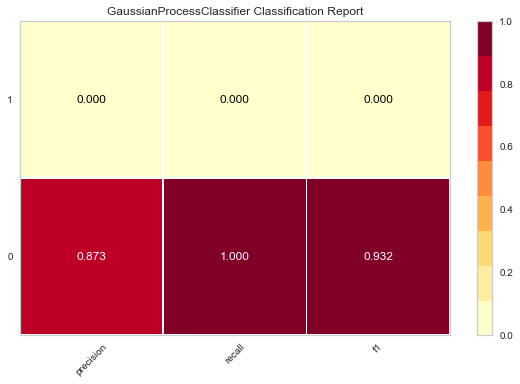

/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


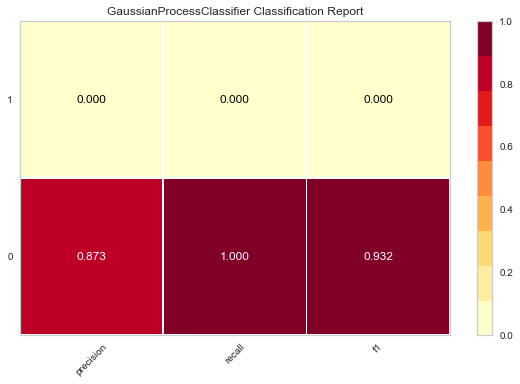

In [83]:
#GPC Accuracy Visualisation
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(GPC, classes=[0,1])
visualizer.fit(data_train, target_train) # Fit the training data to the visualizer
visualizer.score(data_test, target_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

#GPC Accuracy Visualisation with lasso
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(GPC, classes=[0,1])
visualizer.fit(data_new_train, target_train) # Fit the training data to the visualizer
visualizer.score(data_new_test, target_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

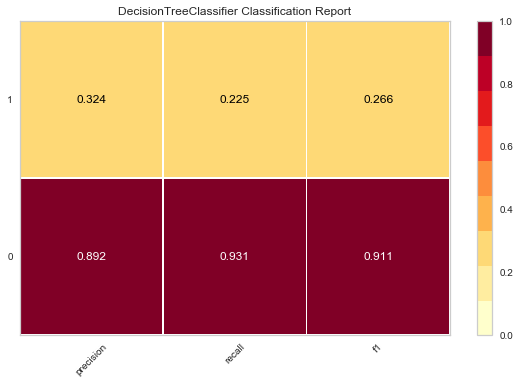

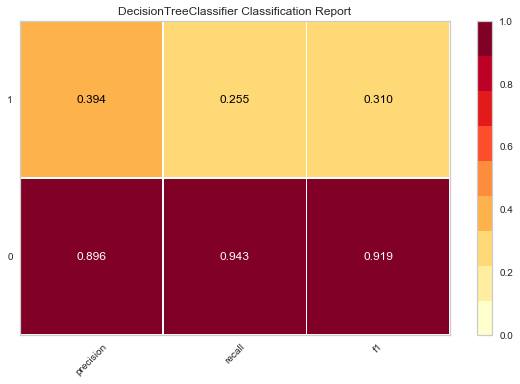

In [84]:
#Dtree Accuracy Visualisation
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(Dtree, classes=[0,1])
visualizer.fit(data_train, target_train) # Fit the training data to the visualizer
visualizer.score(data_test, target_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

#Dtree Accuracy Visualisation with lasso
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(Dtree, classes=[0,1])
visualizer.fit(data_new_train, target_train) # Fit the training data to the visualizer
visualizer.score(data_new_test, target_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

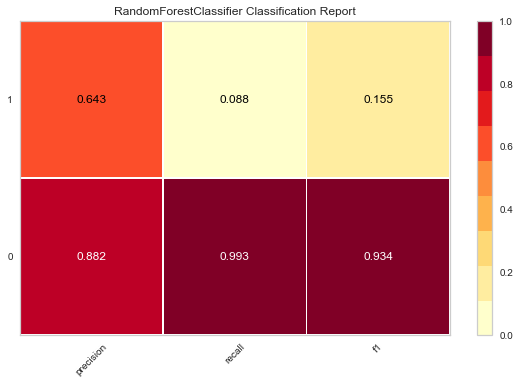

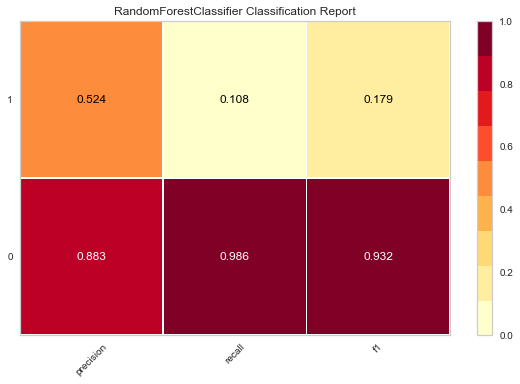

In [85]:
#Rforest Accuracy Visualisation
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(Rforest, classes=[0,1])
visualizer.fit(data_train, target_train) # Fit the training data to the visualizer
visualizer.score(data_test, target_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

#Rforest Accuracy Visualisation with lasso
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(Rforest, classes=[0,1])
visualizer.fit(data_new_train, target_train) # Fit the training data to the visualizer
visualizer.score(data_new_test, target_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

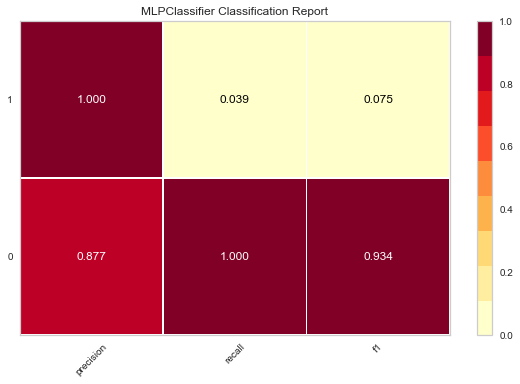

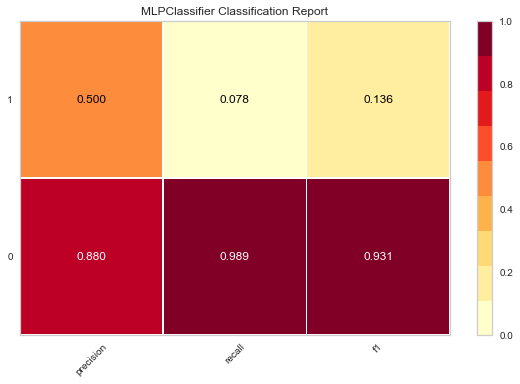

In [86]:
#NN Accuracy Visualisation
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(NN, classes=[0,1])
visualizer.fit(data_train, target_train) # Fit the training data to the visualizer
visualizer.score(data_test, target_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

#NN Accuracy Visualisation with lasso
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(NN, classes=[0,1])
visualizer.fit(data_new_train, target_train) # Fit the training data to the visualizer
visualizer.score(data_new_test, target_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

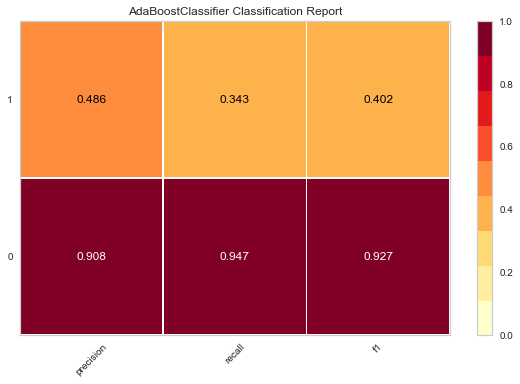

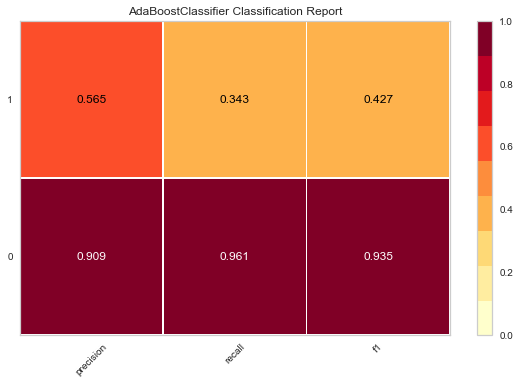

In [87]:
#AdaBoost Accuracy Visualisation
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(AdaBoost, classes=[0,1])
visualizer.fit(data_train, target_train) # Fit the training data to the visualizer
visualizer.score(data_test, target_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

#AdaBoost Accuracy Visualisation with lasso
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(AdaBoost, classes=[0,1])
visualizer.fit(data_new_train, target_train) # Fit the training data to the visualizer
visualizer.score(data_new_test, target_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


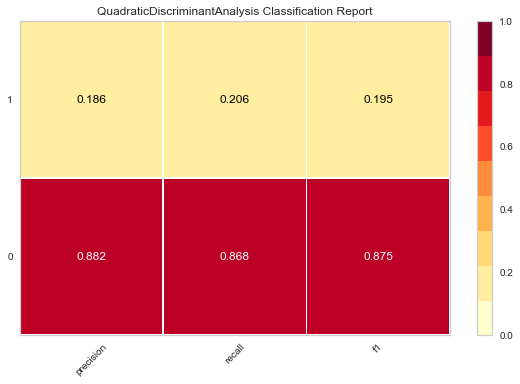

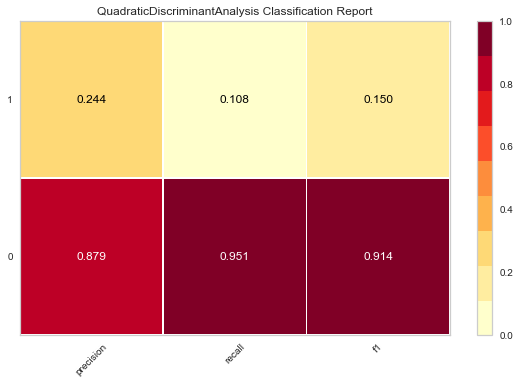

In [88]:
#QuardDisc Accuracy Visualisation
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(QuardDisc, classes=[0,1])
visualizer.fit(data_train, target_train) # Fit the training data to the visualizer
visualizer.score(data_test, target_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

#QuardDisc Accuracy Visualisation with lasso
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(QuardDisc, classes=[0,1])
visualizer.fit(data_new_train, target_train) # Fit the training data to the visualizer
visualizer.score(data_new_test, target_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

In [199]:
concatenated_data = pd.concat([df, target_col])

In [59]:
target_col.name


'In-hospital_death'

In [64]:
def scatter_plot(feature):
    plt.figure(figsize=(16, 8))
    sns.scatterplot(x=target_col,
                    y=df[feature],
                   hue=target_col)
#     plt.scatter(df[feature],
#                target_col,
#                c='black'
#                )
    plt.ylabel(feature)
    plt.xlabel("In-hospital_death")
    plt.show()

In [67]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [71]:
#AdaBoost accuracy
scores = cross_val_score(AdaBoost, df, target_col, cv=5, scoring='neg_mean_squared_error')
print("AdaBoost Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

AdaBoost Accuracy: -0.13 (+/- 0.01)


In [278]:
nn_tuned = MLPClassifier(max_iter=1000)
parameter_space = {
    'hidden_layer_sizes': [(100,100,100), (50,50,50), (50,100,50), (100,50,100), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05, 0.5, 1.0],
    'learning_rate': ['constant','adaptive'],
}
clf = GridSearchCV(nn_tuned, parameter_space, n_jobs=-3, cv=5)
clf.fit(df, target_col)

/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=1000,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_st...
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=-3,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05, 0.5, 1.0],
                         'hidden_l

In [279]:
# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.5, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.855 (+/-0.018) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'solver': 'sgd'}
0.853 (+/-0.008) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'solver': 'adam'}
0.844 (+/-0.018) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.861 (+/-0.007) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.859 (+/-0.014) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.858 (+/-0.009) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', '